# Milestone 3

## Zaawansowane modele i optymalizacja

- Modele ensemble
- Tuning hiperparametrów

## Walidacja i ocena końcowa

- Testowanie modelu na zbiorze testowym
- Użycie metryk i narzędzi do walidacji

## Interpretacja i wyjaśnienie wyników

- Feature importance
- Wykorzystanie narzędzi interpretacyjnych

## Przygotowanie raportu

## Inne

- co z funkcją kosztu? czy piszemy coś co zasymuluje koszt sprawdzenia flagi fraud?

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

filepath = "data/creditcard_csv.csv"

df = pd.read_csv(filepath)

X = df.drop('Class', axis=1)
y = df['Class'].replace({"'0'": 0, "'1'": 1})

# dzielimy
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

## Klasyfikator głosujący

In [7]:
scoring = {
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

def display_scores(scores):
    print("Wyniki f1:", scores['test_f1'])
    print("Średnia f1:", scores['test_f1'].mean())
    print("Odchylenie standardowe f1:", scores['test_f1'].std())
    print("Wyniki auc_roc:", scores['test_roc_auc'])
    print("Średnia auc_roc:", scores['test_roc_auc'].mean())
    print("Odchylenie standardowe auc_roc:", scores['test_roc_auc'].std())

In [4]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier()), ('svc', SVC(kernel='poly', probability=True))],
    voting='soft'
)

cv_voting_clf = cross_validate(voting_clf, X_train_valid, y_train_valid, cv=10, scoring=scoring, n_jobs=-1)

display_scores(cv_voting_clf)

Wyniki f1: [0.71641791 0.88311688 0.8        0.74285714 0.6969697  0.61016949
 0.67741935 0.67692308 0.84931507 0.83783784]
Średnia f1: 0.7491026463009682
Odchylenie standardowe f1: 0.08481908319770355
Wyniki auc_roc: [0.98772135 0.99671729 0.9885174  0.96889501 0.94802929 0.93405642
 0.99634252 0.95304797 0.95688058 0.9865346 ]
Średnia auc_roc: 0.9716742431800907
Odchylenie standardowe auc_roc: 0.02131996558900092


Słabe. Jedyna opcja taka, żeby dostroić te pojedyńcze klasyfikatory na boku i je tu włożyć. Dużo pracy imo

## Agregacja

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier


bag_clf = Pipeline([
    ('Selectkbest', SelectKBest(score_func=f_classif, k=7)),
    ('bagging_clf', BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100,
    bootstrap=True, n_jobs=-1),
     )
])

cv_bag_clf = cross_validate(bag_clf, X_train_valid, y_train_valid, scoring=scoring, cv=5)

display_scores(cv_bag_clf)

Wyniki f1: [0.86956522 0.84415584 0.77987421 0.82993197 0.84210526]
Średnia f1: 0.8331265022661274
Odchylenie standardowe f1: 0.029583967723142382
Wyniki auc_roc: [0.93913673 0.93299324 0.91570373 0.89779018 0.94585849]
Średnia auc_roc: 0.9262964755029218
Odchylenie standardowe auc_roc: 0.0174195665978446


In [6]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

bag_svm_clf = Pipeline([
    ('Selectkbest', SelectKBest(score_func=f_classif, k=10)),
    ('bagging_clf', BaggingClassifier(
    SVC(kernel='poly'), n_estimators=10,
    bootstrap=True, n_jobs=-1),
     )
])

cv_bag_svm_clf = cross_validate(bag_svm_clf, X_train_valid, y_train_valid, scoring=scoring, cv=10)

display_scores(cv_bag_svm_clf)

Wyniki f1: [0.77777778 0.87058824 0.82191781 0.77333333 0.77108434 0.73529412
 0.71428571 0.78378378 0.83783784 0.88607595]
Średnia f1: 0.7971978894895289
Odchylenie standardowe f1: 0.052974665219057186
Wyniki auc_roc: [0.8633211  0.98589379 0.87292885 0.93820184 0.92880197 0.85118893
 0.90564033 0.91892486 0.88433573 0.96771635]
Średnia auc_roc: 0.9116953730405815
Odchylenie standardowe auc_roc: 0.042403309119471884


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_clf = Pipeline([
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('xgb_clf', GradientBoostingClassifier())
])

cv_xgb_clf = cross_validate(xgb_clf, X_train_valid, y_train_valid, scoring=scoring, cv=10, n_jobs=-1)

display_scores(cv_xgb_clf)

Wyniki f1: [0.71232877 0.83950617 0.87804878 0.75       0.75294118 0.76923077
 0.52941176 0.72       0.61971831 0.85714286]
Średnia f1: 0.742832859785985
Odchylenie standardowe f1: 0.10183508292129421
Wyniki auc_roc: [0.80934795 0.96038725 0.95669715 0.89264089 0.91623318 0.91232703
 0.62103382 0.87711287 0.62548031 0.96762127]
Średnia auc_roc: 0.8538881710709593
Odchylenie standardowe auc_roc: 0.12351730544507536


Wszedłbym w drzewa losowe

## Losowe lasy oraz zespół Extra-Trees

Tutaj będzie cały proces

### Losowe lasy

In [11]:
from sklearn.model_selection import GridSearchCV

rnd_clf = Pipeline([
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42)),
])

param_grid = [
    {'SelectKBest__k': [6,8,10]},
    {'Classifier__n_estimators': [50,100,200], 'Classifier__max_depth': [5,10], 'Classifier__criterion': ['gini', 'entropy']},
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [6, 8, 10]},
                         {'Classifier__criterion': ['gini', 'entropy'],
                          'Classifier__max_depth': [5, 10],
                          'Classifier__n_estimators': [50, 100, 200]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [12]:
rnd_grid_search.best_params_

{'Classifier__criterion': 'entropy',
 'Classifier__max_depth': 10,
 'Classifier__n_estimators': 200}

In [13]:
reglog_cv_results = rnd_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.8421879499899052 0.930592056704082 {'SelectKBest__k': 6}
0.850374300464763 0.9303919518939365 {'SelectKBest__k': 8}
0.8562403298602043 0.9413165497995027 {'SelectKBest__k': 10}
0.8291633167453814 0.9626050257800708 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__n_estimators': 50}
0.830815414786875 0.970123757035115 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__n_estimators': 100}
0.8311593513834517 0.9716869038912639 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__n_estimators': 200}
0.8527509260393291 0.9780076646124002 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 50}
0.8543861734817891 0.9781727753326999 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 100}
0.8506728981666709 0.9783016367836991 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 200}
0.8378170014201662 0.979

In [14]:
param_grid = [
    {'SelectKBest__k': [10, 12, 14]},
    {'Classifier__n_estimators': [200, 350, 500], 'Classifier__max_depth': [10, 12, 14], 'Classifier__criterion': ['entropy', 'log_loss']},
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [10, 12, 14]},
                         {'Classifier__criterion': ['entropy', 'log_loss'],
                          'Classifier__max_depth': [10, 12, 14],
                          'Classifier__n_estimators': [200, 350, 500]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [15]:
rnd_grid_search.best_params_

{'Classifier__criterion': 'entropy',
 'Classifier__max_depth': 14,
 'Classifier__n_estimators': 200}

In [16]:
reglog_cv_results = rnd_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.8562403298602043 0.9413165497995027 {'SelectKBest__k': 10}
0.8523658830620857 0.9400760764348531 {'SelectKBest__k': 12}
0.8572082484231197 0.9459716321250025 {'SelectKBest__k': 14}
0.8582139073574601 0.9816720032150352 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 200}
0.8586848064459612 0.9814497513988133 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 350}
0.8573302776221933 0.9817615764118409 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 500}
0.8565334910945239 0.9802573229200906 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 12, 'Classifier__n_estimators': 200}
0.8583500869330362 0.97998121533262 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 12, 'Classifier__n_estimators': 350}
0.8591018272491979 0.9807802683226232 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 12, 'Classifier__n_estimators': 50

In [17]:
param_grid = [
    {'SelectKBest__k': [9,10,11]},
    {'Classifier__n_estimators': [200], 'Classifier__max_depth': [13,14,15], 'Classifier__criterion': ['entropy']},
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [9, 10, 11]},
                         {'Classifier__criterion': ['entropy'],
                          'Classifier__max_depth': [13, 14, 15],
                          'Classifier__n_estimators': [200]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [18]:
rnd_grid_search.best_params_

{'Classifier__criterion': 'entropy',
 'Classifier__max_depth': 14,
 'Classifier__n_estimators': 200}

In [19]:
reglog_cv_results = rnd_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.857429736162455 0.943713802779838 {'SelectKBest__k': 9}
0.8562403298602043 0.9413165497995027 {'SelectKBest__k': 10}
0.8520996656355836 0.9377610083890972 {'SelectKBest__k': 11}
0.8594683424544229 0.980565913292151 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 13, 'Classifier__n_estimators': 200}
0.8605575758017207 0.9808287399214262 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 14, 'Classifier__n_estimators': 200}
0.8580104455126548 0.9808408175049796 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 15, 'Classifier__n_estimators': 200}


criterion = 'entropy'\
max_depth = 14\
n_estimators = 200

In [28]:
rnd_clf = Pipeline([
    ('SelectKBest', SelectKBest(score_func=f_classif, k=9)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=200, max_depth=14, criterion='entropy')),
])

cv_rnd_clf = cross_validate(rnd_clf, X_train_valid, y_train_valid, scoring=scoring, cv=10)

display_scores(cv_rnd_clf)

Wyniki f1: [0.88       0.91954023 0.92307692 0.825      0.82926829 0.83333333
 0.78873239 0.83783784 0.8974359  0.86075949]
Średnia f1: 0.8594984402289059
Odchylenie standardowe f1: 0.04215925380655533
Wyniki auc_roc: [0.98942625 0.981251   0.99483357 0.96771621 0.96790882 0.94604364
 0.99790886 0.97057505 0.96274577 0.99580777]
Średnia auc_roc: 0.9774216930407507
Odchylenie standardowe auc_roc: 0.016282662548613352


### Extra-Trees

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42)),
])

param_grid = [
    {'SelectKBest__k': [8,9,10]},
    {'Classifier__n_estimators': [100,200,300], 'Classifier__max_depth': [5,10], 'Classifier__criterion': ['gini', 'entropy']},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        ExtraTreesClassifier(n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [8, 9, 10]},
                         {'Classifier__criterion': ['gini', 'entropy'],
                          'Classifier__max_depth': [5, 10],
                          'Classifier__n_estimators': [100, 200, 300]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [21]:
ext_grid_search.best_params_

{'SelectKBest__k': 10}

In [22]:
reglog_cv_results = ext_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.8526417665811172 0.941045339358757 {'SelectKBest__k': 8}
0.8616616104800142 0.9472856875595725 {'SelectKBest__k': 9}
0.8627890969345158 0.9508040362005075 {'SelectKBest__k': 10}
0.6583258817518359 0.9687258318052689 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__n_estimators': 100}
0.6594233065779634 0.9722566875486294 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__n_estimators': 200}
0.6542149447848808 0.973183173479522 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__n_estimators': 300}
0.8382216873838436 0.979775801061382 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 100}
0.8334071470854324 0.9802416909257268 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 200}
0.8367637904420757 0.980485991352503 {'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 300}
0.6791751228960532 0.9

In [23]:
param_grid = [
    {'SelectKBest__k': [9,10,11]},
    {'Classifier__n_estimators': [100,200,300], 'Classifier__max_depth': [10,12,14], 'Classifier__criterion': ['entropy']},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        ExtraTreesClassifier(n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [9, 10, 11]},
                         {'Classifier__criterion': ['entropy'],
                          'Classifier__max_depth': [10, 12, 14],
                          'Classifier__n_estimators': [100, 200, 300]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [24]:
ext_grid_search.best_params_

{'SelectKBest__k': 10}

In [25]:
reglog_cv_results = ext_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.8616616104800142 0.9472856875595725 {'SelectKBest__k': 9}
0.8627890969345158 0.9508040362005075 {'SelectKBest__k': 10}
0.8535752665463667 0.9509273525409316 {'SelectKBest__k': 11}
0.8414218296123872 0.9801933689861807 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 100}
0.8398324256388772 0.9814716896488015 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 200}
0.840416658606309 0.9819872220314518 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 300}
0.8474905739421867 0.9807739947587615 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 12, 'Classifier__n_estimators': 100}
0.8449099287808967 0.9813234026443597 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 12, 'Classifier__n_estimators': 200}
0.848213087776655 0.9811344239198837 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 12, 'Classifier__n_estimators': 300

In [26]:
param_grid = [
    {'SelectKBest__k': [10]},
    {'Classifier__n_estimators': [150,250], 'Classifier__max_depth': [14,16,18], 'Classifier__criterion': ['entropy']},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        ExtraTreesClassifier(n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [10]},
                         {'Classifier__criterion': ['entropy'],
                          'Classifier__max_depth': [14, 16, 18],
                          'Classifier__n_estimators': [150, 250]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [27]:
reglog_cv_results = ext_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.8627890969345158 0.9508040362005075 {'SelectKBest__k': 10}
0.8548492515285684 0.9836661460530387 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 14, 'Classifier__n_estimators': 150}
0.8548492515285684 0.9829328116768824 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 14, 'Classifier__n_estimators': 250}
0.8561067053835381 0.9809850323916534 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 16, 'Classifier__n_estimators': 150}
0.8571791812947236 0.9818032403331722 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 16, 'Classifier__n_estimators': 250}
0.8572316019923057 0.9800687719248536 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 18, 'Classifier__n_estimators': 150}
0.8585081467361626 0.9826626278010953 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 18, 'Classifier__n_estimators': 250}


In [29]:
param_grid = [
    {'SelectKBest__k': [10]},
    {'Classifier__n_estimators': [225,275], 'Classifier__max_depth': [18,20], 'Classifier__criterion': ['entropy']},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        ExtraTreesClassifier(n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [10]},
                         {'Classifier__criterion': ['entropy'],
                          'Classifier__max_depth': [18, 20],
                          'Classifier__n_estimators': [225, 275]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [30]:
reglog_cv_results = ext_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.8627890969345158 0.9508040362005075 {'SelectKBest__k': 10}
0.8568832057819822 0.9821535989604883 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 18, 'Classifier__n_estimators': 225}
0.8568832057819822 0.9825220049887647 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 18, 'Classifier__n_estimators': 275}
0.8545959462876993 0.9801806097973274 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 20, 'Classifier__n_estimators': 225}
0.856051694840222 0.9805910131559423 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 20, 'Classifier__n_estimators': 275}


In [31]:
param_grid = [
    {'SelectKBest__k': [10]},
    {'Classifier__n_estimators': [250], 'Classifier__max_depth': [17,18,19], 'Classifier__criterion': ['entropy']},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit='f1', return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        ExtraTreesClassifier(n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [10]},
                         {'Classifier__criterion': ['entropy'],
                          'Classifier__max_depth': [17, 18, 19],
                          'Classifier__n_estimators': [250]}],
             refit='f1', return_train_score=True,
             scoring={'f1': 'f1', 'roc_auc': 'roc_auc'})

In [32]:
reglog_cv_results = ext_grid_search.cv_results_
for f1, auc_roc, params in zip(reglog_cv_results['mean_test_f1'], reglog_cv_results['mean_test_roc_auc'], reglog_cv_results['params']):
    print(f1, auc_roc, params)

0.8627890969345158 0.9508040362005075 {'SelectKBest__k': 10}
0.8572316019923057 0.9795830382039759 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 17, 'Classifier__n_estimators': 250}
0.8585081467361626 0.9826626278010953 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 18, 'Classifier__n_estimators': 250}
0.8600736943460927 0.9822906094402516 {'Classifier__criterion': 'entropy', 'Classifier__max_depth': 19, 'Classifier__n_estimators': 250}


criterion = 'entropy'\
max_depth = 19\
n_estimators = 250

In [33]:
ext_clf = Pipeline([
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42, criterion='entropy', max_depth=19, n_estimators=250)),
])

cv_ext_clf = cross_validate(ext_clf, X_train_valid, y_train_valid, cv=10, n_jobs=-1, scoring=scoring)

display_scores(cv_ext_clf)

Wyniki f1: [0.88       0.91764706 0.93670886 0.82051282 0.825      0.83333333
 0.8115942  0.83333333 0.92307692 0.87179487]
Średnia f1: 0.8653001404532856
Odchylenie standardowe f1: 0.04471455669733119
Wyniki auc_roc: [0.99555573 0.98009092 0.99453111 0.97919832 0.98581497 0.96150364
 0.99808649 0.94537583 0.95577908 0.98931104]
Średnia auc_roc: 0.9785247114033689
Odchylenie standardowe auc_roc: 0.01734142893770733


In [35]:
display_scores(cv_rnd_clf)

Wyniki f1: [0.88       0.91954023 0.92307692 0.825      0.82926829 0.83333333
 0.78873239 0.83783784 0.8974359  0.86075949]
Średnia f1: 0.8594984402289059
Odchylenie standardowe f1: 0.04215925380655533
Wyniki auc_roc: [0.98942625 0.981251   0.99483357 0.96771621 0.96790882 0.94604364
 0.99790886 0.97057505 0.96274577 0.99580777]
Średnia auc_roc: 0.9774216930407507
Odchylenie standardowe auc_roc: 0.016282662548613352


Extra-Trees odrobinę lepsze, a do tego parę razy szybciej się liczą

### Eksperyment z funkcją kosztu

In [19]:
# funkcja kosztu

def custom_cost(estimator, X, y_true):

    y_pred = estimator.predict(X)
    amount = X['Amount'].values

    fp_cost = 5
    tp_cost = 0
    tn_cost = 5

    total_cost = 0

    for true_label, pred_label, fn_cost in zip(y_true, y_pred, amount):
        if true_label == 0 and pred_label == 0: #TP
            total_cost += tp_cost
        elif true_label == 1 and pred_label == 0: #FN
            total_cost += fn_cost
        elif true_label == 0 and pred_label == 1: #FP
            total_cost += fp_cost
        elif true_label == 1 and pred_label == 1: #TN
            total_cost += tn_cost

    return total_cost


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFpr
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import make_scorer

scorer = make_scorer(custom_cost, greater_is_better=False, needs_proba=False)

ext_clf = Pipeline([
    #('SelectKBest', SelectKBest(score_func=SelectFpr, k=10)), # nie można tego użyć bo wtedy nie mamy kolumny Amount
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42, criterion='entropy', max_depth=19, n_estimators=250)),
])

cv_ext_clf = cross_validate(ext_clf, X_train_valid, y_train_valid, cv=10, n_jobs=-1, scoring=custom_cost)

# display_scores(cv_ext_clf)

In [18]:
cv_ext_clf

{'fit_time': array([20.23912144, 20.31276989, 23.94703913, 29.61542559, 20.54346776,
        29.68454409, 28.25336719, 29.36531854, 29.83853793, 29.7275188 ]),
 'score_time': array([9.30426836, 9.28485847, 5.68768001, 0.15263987, 9.05255771,
        0.11482143, 1.46129394, 0.34392571, 0.05441785, 0.07619238]),
 'test_score': array([2996.34,  234.91,  505.24, 1765.92, 3712.65, 1732.64, 1627.69,
         986.03, 1058.98, 2296.76])}

## Zaawansowany tuning (?)

## Testowanie na zbiorze testowym

In [36]:
from sklearn.metrics import f1_score, roc_auc_score

ext_clf.fit(X_train_valid, y_train_valid)

y_pred = ext_clf.predict(X_test)

print("f1: ", f1_score(y_test, y_pred))
print("roc_auc: ", roc_auc_score(y_test, y_pred))

f1:  0.8592592592592593
roc_auc:  0.8918567202543004


In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[42645,     3],
       [   16,    58]])

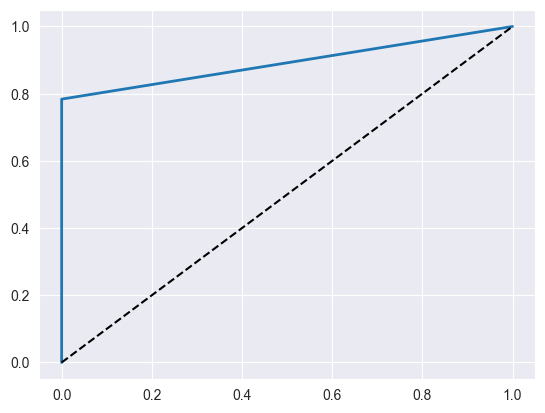

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc(fpr, tpr)
plt.show()

CZy to nie jest jakieś dziwne? Bo takie kanciaste trochę

In [48]:
feature_importance = ext_clf.named_steps['Classifier'].feature_importances_

selected_features_mask = ext_clf.named_steps['SelectKBest'].get_support()
selected_features = X.columns[selected_features_mask]

for feature, importance in zip(selected_features, feature_importance):
    print(f"{feature}: {importance}")

V3: 0.05663343379546188
V4: 0.08552169283458655
V7: 0.030533009740124035
V10: 0.09725008481263248
V11: 0.09565315080857464
V12: 0.14239699493745556
V14: 0.19739333018958
V16: 0.07787161437349106
V17: 0.16343829992448078
V18: 0.05330838858361307


In [49]:
sorted(zip(feature_importance, selected_features), reverse=True)

[(np.float64(0.19739333018958), 'V14'),
 (np.float64(0.16343829992448078), 'V17'),
 (np.float64(0.14239699493745556), 'V12'),
 (np.float64(0.09725008481263248), 'V10'),
 (np.float64(0.09565315080857464), 'V11'),
 (np.float64(0.08552169283458655), 'V4'),
 (np.float64(0.07787161437349106), 'V16'),
 (np.float64(0.05663343379546188), 'V3'),
 (np.float64(0.05330838858361307), 'V18'),
 (np.float64(0.030533009740124035), 'V7')]